# Main script to clean CA fires data

Modules: N/A <br>
Author: Cornelia Ilin & Joy McGillin <br>
Email: cilin@wisc.edu & jmoglia@berkeley.edu <br>
Date created: March 22, 2020 <br>
Date updated: February 2023 <br>

**Citations (data sources)**

``CA fires data:``
1. CAL Fire: Fire perimeters database: https://frap.fire.ca.gov/mapping/gis-data/
2. Data dictionary: https://frap.fire.ca.gov/frap-projects/fire-perimeters/

Layer 0 - accidental wildfires <br>
Layer 1 - prescribed fires <br>
Layer 2 - non-prescribed fire fuel reduction projects <br>

``Shapefiles for California ZIP codes (2010 census):``

Note: CAL Fire also has county bounderies info (check it here: https://frap.fire.ca.gov/mapping/gis-data/)

3. https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=ZIP+Code+Tabulation+Areas

4. How to find if a point is inside a polygon:<br>
https://stackoverflow.com/questions/43892459/check-if-geo-point-is-inside-or-outside-of-polygon <br>
https://medium.com/analytics-vidhya/point-in-polygon-analysis-using-python-geopandas-27ea67888bff
    
**Citations (persons)**
1. N/A

**Preferred environment**
1. Code written in Jupyter Notebooks

### Step 1: Import packages

In [1]:
# standard
import pandas as pd
import numpy as np
import os
from datetime import datetime

# geospatial
import geopandas as gpd
import shapely
from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import Polygon

# ignore warnings
import warnings
warnings.filterwarnings(
    'ignore'
)

### Step 2: Define working directories

In [2]:
in_dir = 'fire21_2.gdb'

### Step 3: Define functions

In [3]:
def clean_fires(gdf):
    '''
    '''
    print(f"Original shape: {gdf.shape}")

    # transform CRS EPSG:3310 to CRS EPSG:4269 (the latter is the lat-lon format); 
    # check here: https://residentmario.github.io/geoplot/user_guide/Working_with_Geospatial_Data.html
    # note the health data is in epsg=4269; check here: https://spatialreference.org/ref/epsg/4269/
    gdf = gdf.to_crs(epsg=4269) 
    
    # edit dates for fires with typos in the year
    gdf.loc[19582,"ALARM_DATE"] = '2016-09-26T00:00:00'
    gdf.loc[21138,"ALARM_DATE"] = '2019-05-29T00:00:00'
    gdf.loc[21138,"CONT_DATE"] = '2019-05-29T00:00:00'
    gdf.loc[339,"CONT_DATE"] = '2020-08-20T00:00:00'
    gdf.loc[15460,"CONT_DATE"] = '1989-08-20T00:00:00'
    gdf.loc[21105,"CONT_DATE"] = '2019-08-21T00:00:00'
    gdf.loc[21426,"CONT_DATE"] = '2021-05-06T00:00:00'   #https://www.fire.ca.gov/incidents/2021/5/2/southern-fire/
    
    
    # drop fires with long >= 1year durations-- likely a typo with the CONT_DATE
    gdf.drop(18908, inplace=True) #PIUTE fire from August 1990 with 3319 day duration
    gdf.drop(18803, inplace=True) #Westlake fire July 8, 2006, 33 acres, burned 366 days
    gdf.drop(13124, inplace=True) #LAVAL fire from June 3, 2012, 41 acres burned for 365 days
    gdf.drop(20618, inplace=True)
    gdf.drop(21451, inplace=True)
    
    # drop if STATE is not California, and then drop the column
    gdf = gdf[gdf.STATE=='CA']
    
    
    # drop cols 
    dropcols = ['AGENCY', 'UNIT_ID', 'INC_NUM', 'COMMENTS', 'REPORT_AC', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'STATE', 'YEAR_']
    gdf.drop(dropcols, inplace=True, axis=1)

    
    # drop if ALARM_DATE is NA 
    # note that there are ~5284 null values for alarm date (~24% of the data).
    gdf = gdf[~(gdf.ALARM_DATE.isna())]
    
    print(f"Shape after alarm date nulls dropped: {gdf.shape}")
    
    # drop if CONT_DATE is NA 
    # 
    gdf = gdf[~(gdf.CONT_DATE.isna())]
    
    print(f"Shape after containment date nulls dropped: {gdf.shape}")

    # add fire centroid
    # use Equal area cylindrical projection:
    # https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
    gdf['fire_centroid'] = gdf.to_crs('+proj=cea').centroid.to_crs(gdf.crs)
    
    # convert to date-time objects
    gdf['ALARM_DATE'] = pd.to_datetime(gdf['ALARM_DATE'])
    gdf['CONT_DATE'] = pd.to_datetime(gdf['CONT_DATE'])
    
     # add duration of fire (in days) variable
    gdf["DURATION"]= gdf['CONT_DATE']-gdf['ALARM_DATE'] 

    
    # add fire geometry area (in KM^2)
    gdf['FIRE_AREA_KM2'] = gdf['geometry'].to_crs('+proj=cea')\
                                 .map(lambda p: p.area / 10**6)
    
    # transform epsg back to 4269
    gdf = gdf.to_crs(epsg=4269)
    print(gdf.shape)
    # drop if fire duration days is negative
    gdf = gdf[~(gdf["DURATION"] < pd.Timedelta(0))]

    print(f"Final shape: {gdf.shape}")
    
    return gdf

### Step 4: Read & Clean data

In [4]:
# read in the first layer of data
data = gpd.read_file(in_dir , layer=0)

In [5]:
# clean data and show first 10 rows
data_clean = clean_fires(data)
data_clean.head(10)

Original shape: (21688, 20)
Shape after alarm date nulls dropped: (16238, 8)
Shape after containment date nulls dropped: (8991, 8)
(8991, 11)
Final shape: (8961, 11)


,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,geometry,fire_centroid,DURATION,FIRE_AREA_KM2
0,NELSON,2020-06-18,2020-06-23,11.0,109.602280,3252.523280,4.435447e+05,"MULTIPOLYGON (((-121.34840 38.88999, -121.3483...",POINT (-121.34806 38.88804),5 days,0.443546
1,AMORUSO,2020-06-01,2020-06-04,2.0,685.585022,9653.760308,2.774464e+06,"MULTIPOLYGON (((-121.35275 38.82038, -121.3526...",POINT (-121.37090 38.82757),3 days,2.774464
3,FLEMING,2020-03-31,2020-04-01,9.0,12.931545,1577.155857,5.233211e+04,"MULTIPOLYGON (((-121.27317 38.96308, -121.2730...",POINT (-121.27341 38.96233),1 days,0.052332
4,MELANESE,2020-04-14,2020-04-19,18.0,10.315964,1035.787625,4.174722e+04,"MULTIPOLYGON (((-121.30065 39.48714, -121.3004...",POINT (-121.30065 39.48636),5 days,0.041747
5,PFE,2020-07-05,2020-07-05,14.0,36.701931,2348.114043,1.485274e+05,"MULTIPOLYGON (((-121.38238 38.72933, -121.3824...",POINT (-121.38102 38.73134),0 days,0.148527
6,VALLEY,2020-07-15,2020-07-16,14.0,376.910400,7596.639583,1.525302e+06,"MULTIPOLYGON (((-121.37698 39.11409, -121.3770...",POINT (-121.36958 39.12976),1 days,1.525303
7,WALDO,2020-07-09,2020-07-12,9.0,10.102212,1104.877978,4.088220e+04,"MULTIPOLYGON (((-121.30435 39.13366, -121.3043...",POINT (-121.30492 39.13463),3 days,0.040882
8,WILLOW,2020-03-10,2020-03-11,5.0,33.973888,1912.358634,1.374875e+05,"MULTIPOLYGON (((-121.31667 39.40193, -121.3165...",POINT (-121.31716 39.39917),1 days,0.137487
9,WILLOWS,2020-09-09,2020-10-13,7.0,1309.089966,11758.463918,5.297699e+06,"MULTIPOLYGON (((-121.33878 39.38178, -121.3387...",POINT (-121.33244 39.37500),34 days,5.297699
10,DYER,2020-07-06,2020-07-06,8.0,194.660294,6043.860007,7.877623e+05,"MULTIPOLYGON (((-121.41211 38.73371, -121.4121...",POINT (-121.41912 38.74358),0 days,0.787762


### Step 5: Save Dropped Data into new CSV

In [28]:
dropped_fires = [18908,18803,13124,20618,21451]
data_dropped = pd.DataFrame()


In [29]:
for x in dropped_fires:
    data_dropped = data_dropped.append(data.loc[x], ignore_index=True)

In [33]:
# fires without alarm or containment dates
data_dropped = data_dropped.append(data.loc[pd.isnull(data[['ALARM_DATE', 'CONT_DATE']]).any(axis=1)], ignore_index=True)

In [37]:
dropcols = ['AGENCY', 'UNIT_ID', 'INC_NUM', 'COMMENTS', 'REPORT_AC', 'C_METHOD', 'OBJECTIVE', 'FIRE_NUM', 'COMPLEX_NAME', 'COMPLEX_INCNUM', 'STATE', 'YEAR_']
data_dropped.drop(dropcols, inplace=True, axis=1)

In [38]:
data_dropped

,FIRE_NAME,ALARM_DATE,CONT_DATE,CAUSE,GIS_ACRES,Shape_Length,Shape_Area,geometry
0,PIUTE,1990-08-13T00:00:00,1999-09-14T00:00:00,1.0,552.472717,10464.029584,2.235778e+06,(POLYGON ((34492.57239999995 -6705.39829999953...
1,WESTLAKE,2006-07-08T00:00:00,2007-07-09T00:00:00,2.0,33.915497,2388.512651,1.372512e+05,(POLYGON ((110627.8627999984 -429788.296400000...
2,LAVAL,2012-06-03T00:00:00,2013-06-03T00:00:00,14.0,41.165211,2058.151152,1.665897e+05,"(POLYGON ((99011.7666000016 -336479.142, 99007..."
3,GORGE,2018-08-19T00:00:00,2019-08-19T00:00:00,14.0,154.562424,3715.129539,6.254919e+05,(POLYGON ((-242200.1183000002 262920.988299999...
4,TIVY,2021-09-07T00:00:00,2022-09-07T00:00:00,2.0,25.031429,1905.579127,1.012986e+05,(POLYGON ((55069.71249999851 -137566.677999999...
...,...,...,...,...,...,...,...,...
12676,PORT,2021-06-27T00:00:00,None,14.0,57.026318,2245.151247,2.307773e+05,(POLYGON ((-177467.0335000008 4701.58200000040...
12677,TURTLE MOUNTAIN,None,None,14.0,1075.475830,11656.667378,4.352296e+06,(POLYGON ((-6351.855900000781 230938.638499999...
12678,EAST,None,2008-06-29T00:00:00,1.0,39.796280,1519.756229,1.610498e+05,(POLYGON ((-253464.0953000002 318555.886600000...
12679,COLEMAN 1,None,None,14.0,155.260223,3781.456309,6.283158e+05,(POLYGON ((-181509.9006999992 268008.136600000...


(-124.91495332869688,
 -113.62312384078403,
 32.051730309835825,
 42.593477355608556)

<Figure size 1000x1000 with 0 Axes>

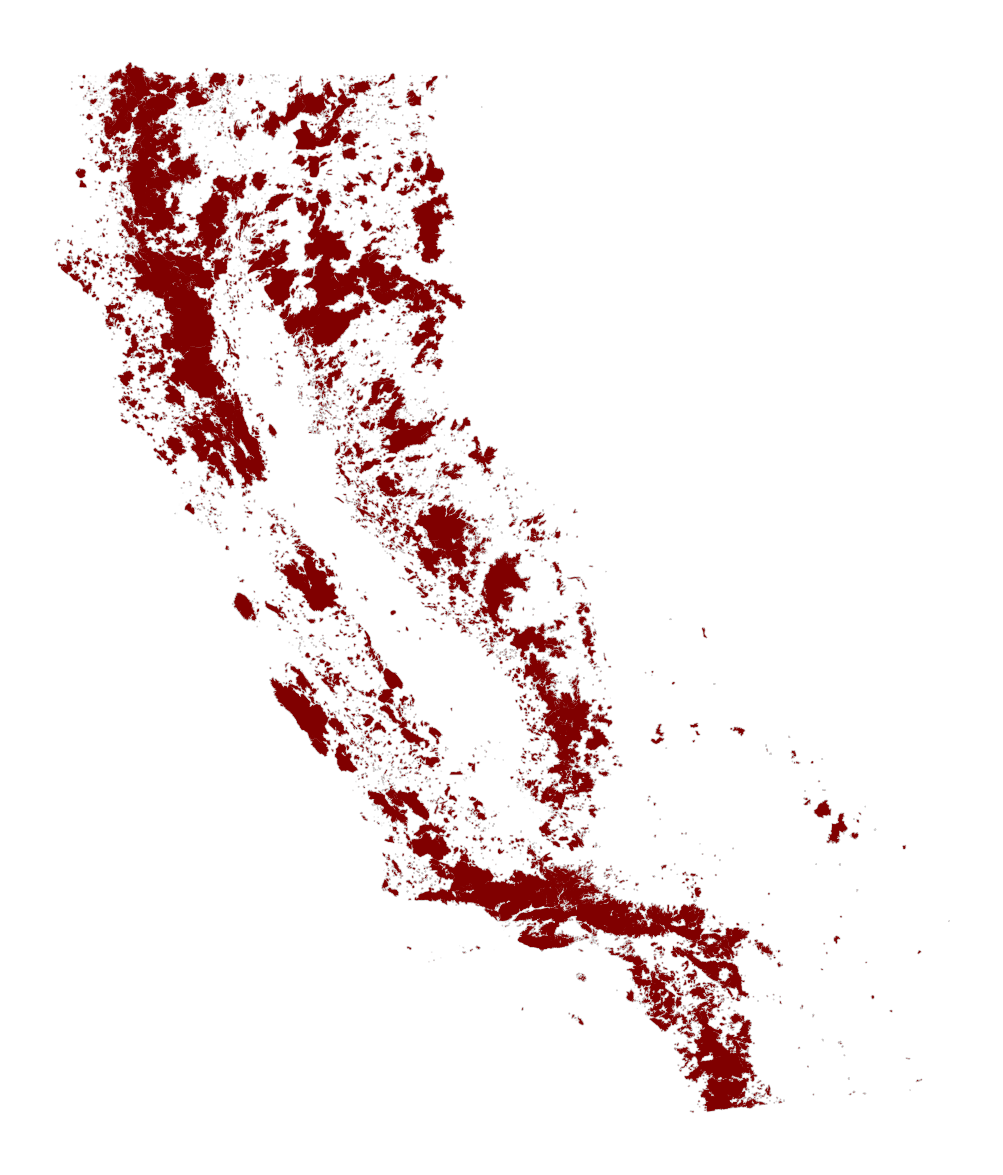

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
# plot base


fig, ax = plt.subplots(1, 1, figsize=(15,15))

data_clean.plot(
    ax=ax,
    cmap=None,
    edgecolor='lightgrey',
    facecolor='none'
)

data_clean.geometry.plot(
    ax=ax,
    facecolor='maroon',
)
# set axis off
ax.axis("off")

# plt.savefig(out_dir + "Fig3c.pdf")

---

### Step 5: Export to .csv

In [12]:
data_clean.to_csv('fires_clean.csv', index_label='Index')

In [39]:
data_dropped.to_csv('fires_dropped.csv', index_label='Index')